In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

from torch.utils.data import Dataset, DataLoader

import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

from scipy import ndimage as ndi
from scipy import fft, ifft
import scipy
from scipy.io import loadmat

from skimage import data
from skimage import io, transform, color
from skimage.util import img_as_float, pad
from skimage.filters import gabor_kernel


import pickle 
import os
import sys
import h5py
import warnings
import time
import json
import nibabel as nib

import gfb_utils as g
import nsd_utils as n

sys.path.append('/user_data/mmhender/coco_annot/cocoapi/PythonAPI/')
from pycocotools.coco import COCO

sys.path.append('/user_data/mmhender/nsd-master/')
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import get_value, set_value
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

In [2]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())

#device: 1
device#: 0
device name: GeForce RTX 3090

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [3]:

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"


In [4]:
subject = 1
nSamples = 20

exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
# ordering is 30000 values in the range [0-9999], which provide a list of trials in order. 
# the value in ordering[ii] tells the index into the subject-specific stimulus array that we would need to take to
# get the image for that trial.

image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

trn_stim_data = image_uncolorize_fn(image_data)
trn_stim_data = trn_stim_data[ordering[0:nSamples]]

# Defining which images to analyze here - first nSamples trials in this subject's full sequence.
nsd_inds = n.get_nsd_inds_by_subject(subj=subject, trial_inds=np.arange(0,nSamples))


block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


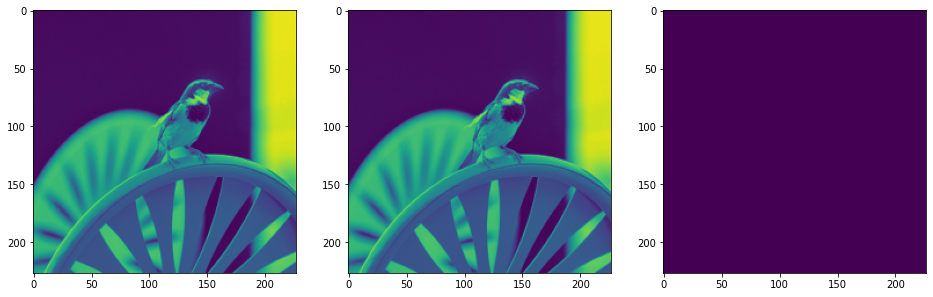

In [5]:
# Making sure preproc is totally matched across pipelines

image_ind = 6

nsd_ind = nsd_inds[image_ind]
# gather metadata for these images and load the one of interest
nsd_brick_file = '/lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5'

with h5py.File(nsd_brick_file, "r") as f:
    nsd_im = f['imgBrick'][nsd_ind,:,:,:] 
nsd_im = g.preproc_for_filt(nsd_im, desired_size = (227,227), grayscale=True)

# nsd_im = resize_image(nsd_im, (227,227))
# nsd_im = nsd_im.astype('float32')/255
# nsd_im = np.mean(nsd_im,axis=2)
# nsd_im = image_uncolorize_fn2(nsd_im)

nsd_im2 = trn_stim_data[image_ind,0,:,:]

plt.figure(figsize=(16,16));
plt.subplot(1,3,1)
plt.imshow(nsd_im)

plt.subplot(1,3,2)
plt.imshow(nsd_im2)

plt.subplot(1,3,3)
plt.imshow(nsd_im2 - nsd_im)


In [9]:


class add_nonlinearity(L.Module):
    def __init__(self, _fmaps_fn, _nonlinearity):
        super(add_nonlinearity, self).__init__()
        self.fmaps_fn = _fmaps_fn
        self.nl_fn = _nonlinearity
    def forward(self, _x):
        return [self.nl_fn(_fm) for _fm in self.fmaps_fn(_x)]

In [22]:
## Method 1 Gaborizer

n_ori=4
n_sf=3

cyc_per_stim = logspace(n_sf)(3., 72.) # 6-92

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=4.13, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

In [58]:
## Method 2

# First define the feature bank itself
freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
spat_aspect_ratio = 1
n_sd_out = 7

process_at_size = [227,227]

bank = g.filter_bank(orients_deg, freqs_cpp, spat_freq_bw, spat_aspect_ratio, n_sd_out, image_size = process_at_size)

all_feat = g.get_nsd_gabor_feat(nsd_inds, bank)
                            
print(np.shape(all_feat))    
# Create set of candidate RFs
sizes = np.arange(5, 21, 5)
x_centers = np.arange(20, 181, 20)
y_centers = np.arange(20, 181, 20)
rf_stack, x_list, y_list, size_list  = g.get_rf_stack(x_centers, y_centers, sizes, process_at_size)

# Making a full matrix, [nIms x nFeatures x nRFs]
feats_by_rfs = g.get_feats_by_rfs(all_feat, rf_stack)

print(np.shape(feats_by_rfs))
nFeats = np.shape(feats_by_rfs)[1]
nRFs = np.shape(feats_by_rfs)[2]

  0%|          | 0/20 [00:00<?, ?it/s]

size of filter stack will be:
(681, 681, 12)


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


(20, 227, 227, 12)
torch.Size([20, 12, 324])


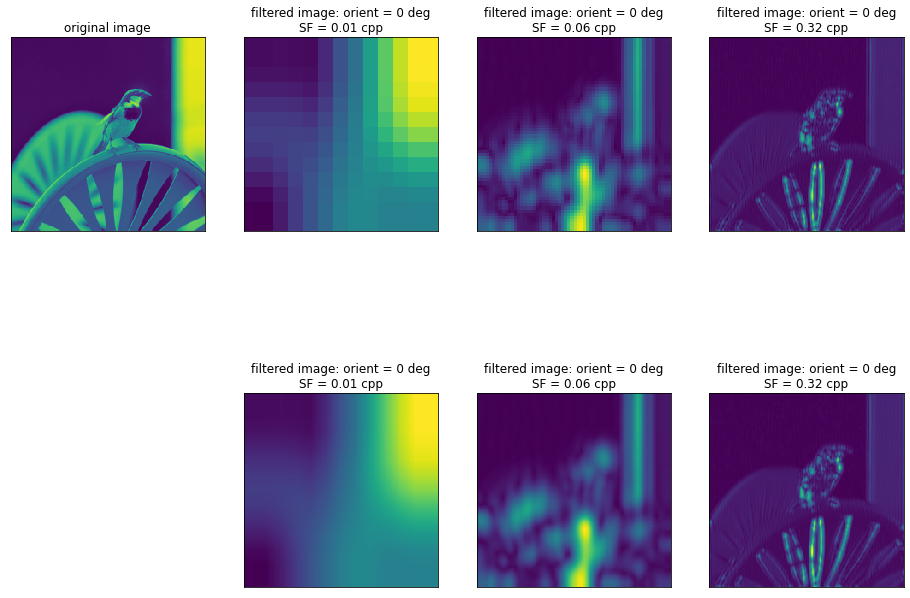

In [57]:
## Results for method 1

_x = torch.tensor(trn_stim_data).to(device) # the input variable.
_fmaps = _gaborizer(_x)

image_ind = 6

nFilts = np.shape(all_feat)[3]

orient_labs = np.unique(np.array(_gaborizer.feature_table['orientation']))/np.pi*180
freq_labs = np.unique(np.array(_gaborizer.feature_table['cycles per stimulus']))/227

plt.figure(figsize=(16,12));

plt.subplot(2,4,1)
plt.pcolormesh(trn_stim_data[image_ind,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

ori2plot = 0
for sf in range(n_sf):

    plt.subplot(2,4,2+sf)
#     ori2plot = ori2plot+1
    featmap = _fmaps[sf][image_ind,ori2plot,:,:].detach().cpu().numpy()
    plt.pcolormesh(featmap)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ori2plot],freq_labs[sf]))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,4,2+sf+4)
#     ori2plot = ori2plot+1
    featmap_upsampled = np.asarray(Image.fromarray(featmap).resize((227,227), resample=Image.BILINEAR))

    plt.pcolormesh(featmap_upsampled)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ori2plot],freq_labs[sf]))
    plt.xticks([])
    plt.yticks([])

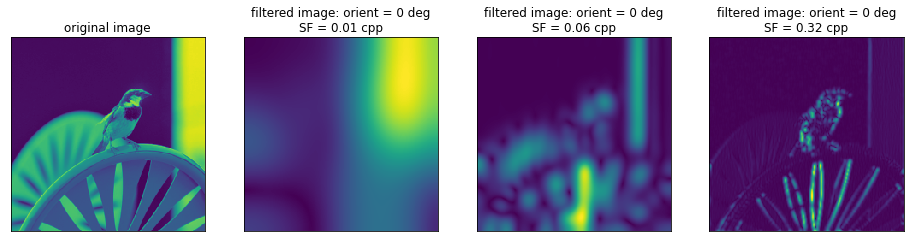

In [48]:
## Results for method 2

image_ind = 6
nsd_ind = nsd_inds[image_ind]
# gather metadata for these images and load the one of interest
nsd_brick_file = '/lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5'

with h5py.File(nsd_brick_file, "r") as f:
    nsd_im = f['imgBrick'][nsd_ind,:,:,:] 
nsd_im = g.preproc_for_filt(nsd_im, desired_size = (227,227), grayscale=True)
    
nFilts = np.shape(all_feat)[3]

orient_labs = bank.orient_labs
freq_labs = bank.freq_labs

plt.figure(figsize=(16,12));

plt.subplot(2,4,1)
plt.pcolormesh(nsd_im)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in range(np.min([nFilts, 3])):
    
    plt.subplot(2,4,2+ii)
    plt.pcolormesh(all_feat[image_ind,:,:,ii])
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))
    plt.xticks([])
    plt.yticks([])